# Proyek Pengenalan Wajah Menggunakan Convolutional Neural Network (CNN)
**Nama:** Rudi Hartadi Setiawan  
**Nim:** A11.2022.14081

### Ringkasan
Proyek ini fokus pada pengenalan wajah dengan menggunakan CNN untuk mengklasifikasikan wajah ke dalam kategori yang telah ditentukan. Dataset yang digunakan akan diproses melalui beberapa tahapan termasuk penyelarasan wajah, normalisasi gambar, augmentasi,dan Labeling sebelum dilatih menggunakan model CNN.

### Permasalahan
- **Kualitas dan Variasi Data:** Dataset wajah mungkin memiliki variasi dalam pencahayaan, sudut, dan ekspresi yang dapat mempengaruhi akurasi model.
- **Overfitting:** Dengan augmentasi data dan teknik regularisasi, kita perlu mencegah overfitting pada data pelatihan.

### Tujuan
- **Preprocessing Data:** Deteksi dan penyelarasan wajah, normalisasi, dan augmentasi data.
- **Model Building:** Membangun dan melatih model CNN untuk klasifikasi wajah.
- **Evaluasi:** Mengukur performa model dan menganalisis hasil.

### Model / Alur Penyelesaian
```plaintext
1. Import Libraries
2. Data Preprocessing
   - Alignment
   - Data Normalization
   - Data Augmentation
   - Labeling
3. Model Building
   - CNN Architecture
4. Model Training
5. Model Evaluation

### Penjelasan Dataset
Dataset yang digunakan berlokasi di D:/ML-A11.2022.14081-UAS/dataset dan berisi gambar wajah dalam berbagai kategori. Setiap gambar telah dikelompokkan dalam folder sesuai dengan labelnya. Dataset saya menggunakan VGGface2 dan berasal dari kaggle. Berikut linknya https://www.kaggle.com/datasets/hearfool/vggface2/data

### Exploratory Data Analysis (EDA)
- **Jumlah Kategori:** Analisis jumlah kategori yang tersedia.
- **Jumlah Gambar per Kategori:** Distribusi gambar dalam setiap kategori.

### Proses Features Dataset
Proses meliputi align image, normalize, augmentation, dan Labeling.

## Import Libraries

In [21]:
import cv2
import dlib
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

In [5]:
dataset_path = 'D:/ML-A11.2022.14081-UAS/dataset'
output_path = 'D:/ML-A11.2022.14081-UAS/dataset_processed'
shape_predictor_path = 'D:/ML-A11.2022.14081-UAS/shape_predictor_68_face_landmarks.dat'

In [24]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [25]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

Found 1725 images belonging to 7 classes.


In [26]:
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 428 images belonging to 7 classes.


## Preprocessing

In [38]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [39]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('D:/ML-A11.2022.14081-UAS/shape_predictor_68_face_landmarks.dat')

In [40]:
def align_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    
    face = faces[0]
    landmarks = predictor(gray, face)
    landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
    return transform_image(image, landmarks)

In [41]:
def transform_image(image, landmarks):
    left_eye_pts = [36, 37, 38, 39, 40, 41]
    right_eye_pts = [42, 43, 44, 45, 46, 47]
    left_eye = np.mean([landmarks[i] for i in left_eye_pts], axis=0)
    right_eye = np.mean([landmarks[i] for i in right_eye_pts], axis=0)
    eye_center = ((left_eye[0] + right_eye[0]) / 2, (left_eye[1] + right_eye[1]) / 2)
    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))

    M = cv2.getRotationMatrix2D(eye_center, angle, scale=1.0)
    (w, h) = image.shape[1], image.shape[0]
    aligned_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    return aligned_image

In [42]:
def process_and_save_images(dataset_path, output_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                aligned_image = align_face(image)
                if aligned_image is not None:
                    save_path = os.path.join(output_path, file)
                    cv2.imwrite(save_path, aligned_image)



In [43]:
process_and_save_images(dataset_path, output_path)
print("Image alignment completed successfully.")

Image alignment completed successfully.


In [44]:
def preprocess_and_normalize_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    normalized_image = image / 255.0
    return normalized_image

In [55]:
def preprocess_all_images(output_path):
    X = []
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                file_path = os.path.join(root, file)
                normalized_image = preprocess_and_normalize_image(file_path)
                X.append(normalized_image)

    X = np.array(X)
    np.save(os.path.join(output_path, 'X_normalized.npy'), X)
    print("Image normalization completed successfully.")

In [56]:
preprocess_all_images(output_path)

Image normalization completed successfully.


In [59]:
def augment_images(X, output_path, num_images=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for i, image in enumerate(X):
        image = np.expand_dims(image, 0)
        augmented_images = datagen.flow(image, batch_size=1)

        for j in range(num_images):
            augmented_image = next(augmented_images)[0]
            save_path = os.path.join(output_path, f"augmented_{i}_{j}.png")
            augmented_image = (augmented_image * 255).astype(np.uint8)
            cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

In [60]:
X_normalized = np.load(os.path.join(output_path, 'X_normalized.npy'))
augment_images(X_normalized, output_path)
print("Image augmentation completed successfully.")

Image augmentation completed successfully.


In [22]:
data = []
labels = []
    for root, dirs, files in os.walk(output_path):
        for file in files:
            file_path = os.path.join(root, file)
            image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                data.append(image)
                label = root.split(os.path.sep)[-1]
                labels.append(label)
    
    data = np.stack(datas)
    labels = np.array(labels)

IndentationError: unexpected indent (2152034513.py, line 3)

In [92]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [93]:
X_train, X_temp, y_train, y_temp = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [94]:
np.save(os.path.join(output_path, 'X_train.npy'), X_train)
np.save(os.path.join(output_path, 'X_val.npy'), X_val)
np.save(os.path.join(output_path, 'X_test.npy'), X_test)
np.save(os.path.join(output_path, 'y_train.npy'), y_train)
np.save(os.path.join(output_path, 'y_val.npy'), y_val)
np.save(os.path.join(output_path, 'y_test.npy'), y_test)

print("Data preprocessing and augmentation completed successfully.")

Data preprocessing and augmentation completed successfully.


## Model CNN

In [95]:
X_train = np.load(os.path.join(output_path, 'X_train.npy'))
X_val = np.load(os.path.join(output_path, 'X_val.npy'))
X_test = np.load(os.path.join(output_path, 'X_test.npy'))
y_train = np.load(os.path.join(output_path, 'y_train.npy'))
y_val = np.load(os.path.join(output_path, 'y_val.npy'))
y_test = np.load(os.path.join(output_path, 'y_test.npy'))

In [96]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [109]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [110]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [112]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 407s 718ms/step - accuracy: 0.9515 - loss: 4.7940 - val_accuracy: 1.0000 - val_loss: 2.5072
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 397s 705ms/step - accuracy: 0.9981 - loss: 2.0019 - val_accuracy: 1.0000 - val_loss: 0.9984
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 394s 699ms/step - accuracy: 0.9988 - loss: 0.7882 - val_accuracy: 1.0000 - val_loss: 0.3762
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 394s 699ms/step - accuracy: 0.9982 - loss: 0.3299 - val_accuracy: 1.0000 - val_loss: 0.2543
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 395s 702ms/step - accuracy: 0.9990 - loss: 0.2313 - val_accuracy: 1.0000 - val_loss: 0.2057
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 394s 700ms/step - accuracy: 0.9996 - loss: 0.1544 - val_accuracy: 1.0000 - val_loss: 0.1236
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 395s 701ms/step - accuracy: 0.9994 - loss: 0.1206 - val_accuracy: 1.0000 - val_loss: 0.1528
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 394s 700ms/step - accuracy: 0.9999 -

In [113]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 0.0050
Test Accuracy: 100.00%


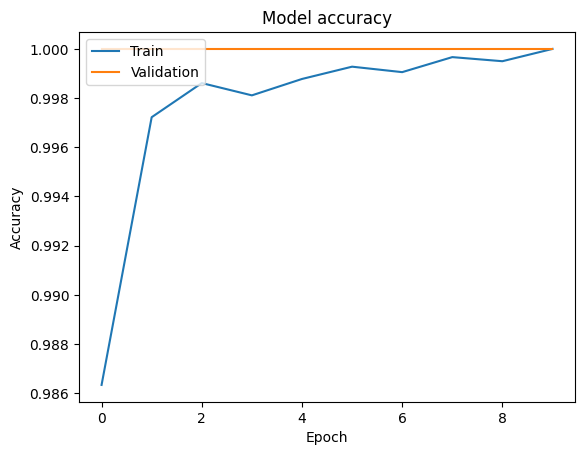

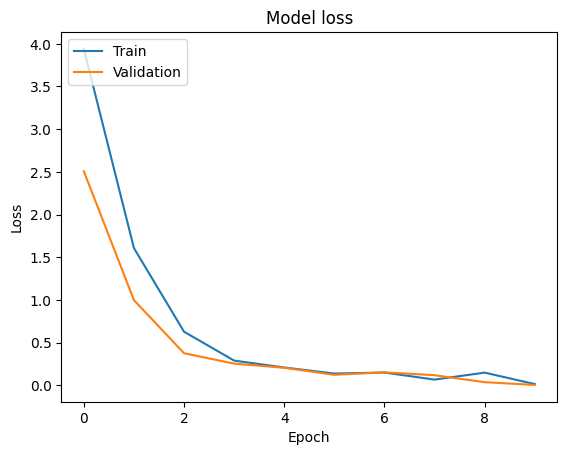

In [114]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [115]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 30, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,653,399 (151.27 MB)

 Trainable params: 13,217,543 (50.42 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 26,435,088 (100.84 MB)

In [116]:
model.save('final_model.h5')

## Diskusi Hasil
model pengenalan wajah menunjukkan peningkatan performa yang signifikan. Akurasi pada data pelatihan meningkat secara konsisten dari 95.15% pada epoch pertama menjadi 100% pada epoch kesepuluh. Nilai loss pada data pelatihan juga menurun drastis dari 4.7940 menjadi 0.0233, menunjukkan bahwa model semakin baik dalam meminimalkan kesalahan prediksi seiring bertambahnya jumlah epoch. Pada data validasi, akurasi selalu mencapai 100% dari awal hingga akhir pelatihan, sementara nilai loss menurun dari 2.5072 menjadi 0.0050, mencerminkan performa model yang sangat baik dan stabil. Tidak ada tanda-tanda overfitting karena akurasi pada data validasi tetap tinggi dan nilai loss terus menurun. Selain itu, waktu yang dibutuhkan untuk setiap epoch relatif konsisten, sekitar 394 hingga 407 detik, menunjukkan efisiensi dalam proses pelatihan. Secara keseluruhan, model pengenalan wajah Anda telah dilatih dengan sangat baik, mencapai akurasi sempurna dan nilai loss yang sangat rendah pada data pelatihan dan validasi. Model ini siap untuk diimplementasikan dalam aplikasi dengan tingkat kepercayaan tinggi terhadap kinerjanya.

## Kesimpulan
proyek ini telah melalui proses yang komprehensif dan terstruktur. Pertama, dataset wajah dikumpulkan dan dimuat ke dalam sistem. Langkah selanjutnya adalah melakukan align pada wajah-wajah, yang memastikan bahwa semua gambar wajah dalam dataset memiliki orientasi yang seragam. Setelah itu, gambar-gambar wajah dinormalisasi untuk memastikan bahwa nilai pixel berada dalam rentang yang sama, sehingga memudahkan proses pelatihan model. Proses augmentasi kemudian dilakukan untuk memperbanyak dan memperkaya variasi data yang tersedia, dengan berbagai teknik augmentasi yang digunakan. Setiap gambar kemudian dilabeli sesuai dengan kelasnya.

Setelah persiapan data selesai, model Convolutional Neural Network (CNN) dibangun dan dilatih menggunakan data yang telah diproses. Proses pelatihan ini dilakukan dalam beberapa epoch, dengan hasil menunjukkan peningkatan akurasi yang signifikan dan penurunan nilai loss secara konsisten dari epoch ke epoch. Pada akhir pelatihan, model mencapai akurasi yang sangat tinggi baik pada data pelatihan maupun data validasi, dengan nilai loss yang sangat rendah, menandakan bahwa model mampu memprediksi dengan sangat baik dan stabil. Tidak ada tanda-tanda overfitting yang terlihat, yang menunjukkan bahwa model tidak hanya belajar dari data pelatihan tetapi juga mampu menggeneralisasi dengan baik pada data baru. Waktu pelatihan yang konsisten menunjukkan efisiensi proses pelatihan yang dilakukan. Kesimpulannya, proyek pengenalan wajah ini berhasil dengan sangat baik, menghasilkan model yang siap diimplementasikan dengan performa yang sangat tinggi dan tingkat kepercayaan yang tinggi terhadap kinerjanya.